# lin_reg.ipynb
An ipython notebook cataloging the process we went through to create a ridge regression model for hubway ridership.

## Final working code

In [1]:
"""
Import necessary modules
"""

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from pprint import pprint

print "modules imported"

modules imported


In [3]:
#load weather data
from weather_collection import *
weather = pickle.load(open('LargeDataStorage/weatherDataFile', 'rb'))

#load hubway data
from hubway_collection import *
hubway = pickle.load(open('LargeDataStorage/hubwayDataFile', 'rb'))

print "weather and hubway data loaded"

weather and hubway data loaded


In [4]:
def count_riders2(year, month, day, hour):
    """
    Input: year, month, day, hour
    Output: total riders during that hour
    """

    #initialize counter
    counter = 0

    #counts riders during a given hour
    for minute in range(0,60):
        #-1 means that there is no data for that time, so we don't count that
        if hubway.data[year][month][day][hour][minute] == -1:
            pass
        else:
            counter += len(hubway.data[year][month][day][hour][minute])
    return counter

In [5]:
def process_data2():
    """
    Warning: hard-coded for hubway data from 2013
    Output: Array formatted array([year, month, day, hour, temp, precip, snow*, riders])
    Note: * data is binary, units are in imperial (english) units
    """
    
    year = 2013
    
    # not a leap year, also taking into account dates hubway was open
    # 2013 start = 4/2/2013
    # 2013 end = 11/30/2013
    numDaysInMonth = [29, 31, 30, 31, 31, 30, 31, 30]
    
    # initalize main list for data
    all_data = []
    
    for index in range(sum(numDaysInMonth)):
        # initalize list that will be appended to all_data
        curr_list = [year]

        for month in range(4, 6):
            for day in range(numDaysInMonth[month-4]):
                for hour in range(0,24):
                    # this is here to make sure that data for April starts on the 2nd
                    if month == 4:
                        tempi = int(float(weather.data[year][month][day+2][hour]['tempi']))
                        if int(float(weather.data[year][month][day+2][hour]['precipi'])) < 0:
                            precipi = 0
                        else: 
                            precipi = int(float(weather.data[year][month][day+2][hour]['precipi']))
                        snow = int(weather.data[year][month][day+2][hour]['snow'])
                        riders = count_riders2(year, month, day+2, hour)
                        curr_list = [year, month, day+2, hour, tempi, precipi, snow, riders]
                        all_data.append(curr_list)
                    else:
                        tempi = int(float(weather.data[year][month][day+1][hour]['tempi']))
                        if int(float(weather.data[year][month][day+1][hour]['precipi'])) < 0:
                            precipi = 0
                        else:
                            precipi = int(float(weather.data[year][month][day+1][hour]['precipi']))
                        snow = int(weather.data[year][month][day+1][hour]['snow'])
                        riders = count_riders2(year, month, day+1, hour)
                        curr_list = [year, month, day+1, hour, tempi, precipi, snow, riders]
                        all_data.append(curr_list)
    
    return np.array(all_data)

In [6]:
data_array = process_data2()

In [7]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    X = data_array[:,[1,2,3,4,5,6]]
    Y = data_array[:,7]

    # make array vertical so that scikit-learn can process it
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(6, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

#         y_plot = model.predict(X)
#         plt.plot(X, y_plot)
#         plt.show()

lin_reg()

MemoryError: 

## Old code
This evolved into our model creation code.

We originally started out only correlating aggregate ridership vs. temperature.  Our process data function would effectively return temperatures and the total number of hubway rides that happened at specific temperatures through a given year.

Our linear regression started off with a workaround. Because you cannot run a linear regression on a set of data that is not linear (our data at this time looked like a normal curve), we took the natural log of our data in order to make it more linear.

After that, we evolved to using PolynomialFeatures to break down our non-linear data into a form that can be analyzed by a linear regression (check scikit-learn documentation for how this occurs mathematically).

We also tried using a support vector regression, but chose not to continue with that code because our ridge regression code was working with no problems.

In [8]:
def count_riders(year, month, day, hour):
    """
    Input: year, month, day, hour
    Output: total riders during that hour
    """

    #initialize counter
    counter = 0

    #counts riders during a given hour
    for minute in range(0,60):
        #-1 means that there is no data for that time, so we don't count that
        if hubway.data[year][month][day+1][hour][minute] == -1:
            pass
        else:
            counter += len(hubway.data[year][month][day+1][hour][minute])
    return counter

In [9]:
def process_data(year):
    """
    Returns 2 lists, 1 of temperatures, 1 of associated ridership.
    """

    #determines whether or not it is a leap year
    if year % 4 == 0:
        numDaysInMonth = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        numDaysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    riders_vs_temp = {}

    #adds all hourly temperatures in given year to dictionary as keys with values of 0
    for m in range(1,13):
        for d in range(numDaysInMonth[m-1]):
            for h in range(0,24):
                if int(float(weather.data[year][m][d+1][h]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][m][d+1][h]['tempi']))] = 0

    #adds number of riders to associated temperature in the dictionary
    for month in range(1,13):
        for day in range(numDaysInMonth[month-1]):
            for hour in range(24):
                if int(float(weather.data[year][month][day+1][hour]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][month][day+1][hour]['tempi']))] += count_riders(year, month, day, hour)

    return riders_vs_temp.keys(), riders_vs_temp.values()

In [10]:
"""
Straight up linear regression by taking the log of polynomial data to make it more resemble a linear dataset.
"""

def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)
    
    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)
    
    # take the log of the data so that you can use a linear regression
    temps = np.log(temps)
    rides = np.log(rides)
    
    # removes infinity from log and sets to 0
    for i in range(len(rides)):
        if rides[i] == -np.inf:
            rides[i] = 0
    
    for i in range(len(temps)):
        if temps[i] == -np.inf:
            temps[i] = 0
            
    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)

    model = LinearRegression()
    model.fit(X_train, y_train)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

2011
Train R2 0.226998
Test R2 0.362191
2012
Train R2 0.758009
Test R2 0.674245
2013
Train R2 0.796410
Test R2 0.605153


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log


Year 2011, 3 degree polynomial regression
Train R2 0.665164
Test R2 0.590851


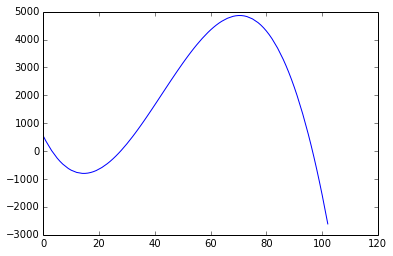

Year 2011, 4 degree polynomial regression
Train R2 0.669325
Test R2 0.583124


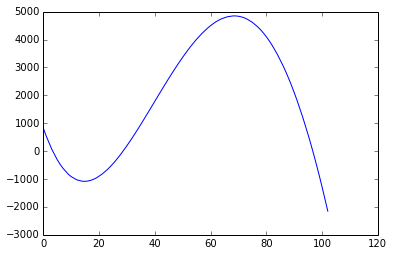

Year 2011, 5 degree polynomial regression
Train R2 0.757012
Test R2 0.734414


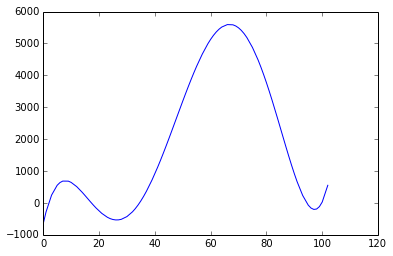

Year 2011, 6 degree polynomial regression
Train R2 0.769807
Test R2 0.756579


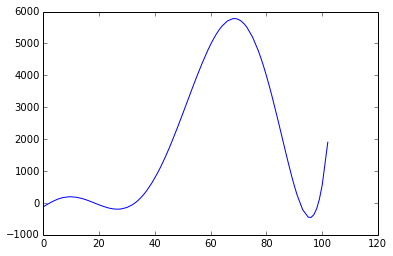

Year 2011, 7 degree polynomial regression
Train R2 0.775459
Test R2 0.765576


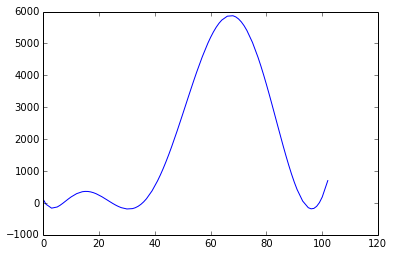

Year 2011, 8 degree polynomial regression
Train R2 0.775924
Test R2 0.776329


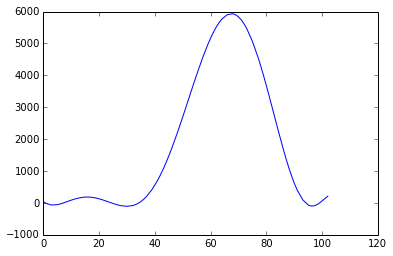

Year 2011, 9 degree polynomial regression
Train R2 0.776483
Test R2 0.772172


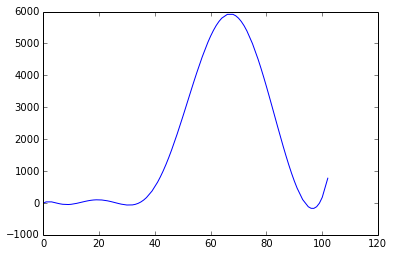

Year 2011, 10 degree polynomial regression
Train R2 0.792449
Test R2 0.600181


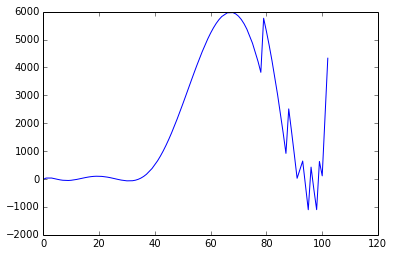

Year 2012, 3 degree polynomial regression
Train R2 0.694628
Test R2 0.712945


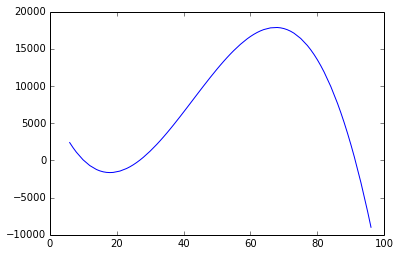

Year 2012, 4 degree polynomial regression
Train R2 0.697971
Test R2 0.695050


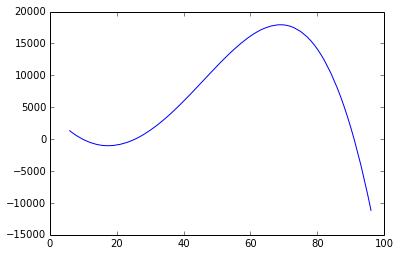

Year 2012, 5 degree polynomial regression
Train R2 0.722331
Test R2 0.793103


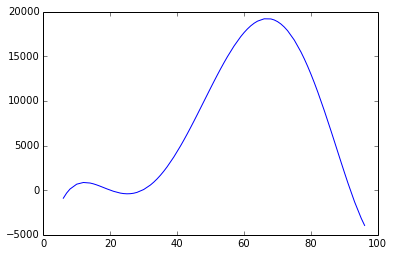

Year 2012, 6 degree polynomial regression
Train R2 0.745348
Test R2 0.786289


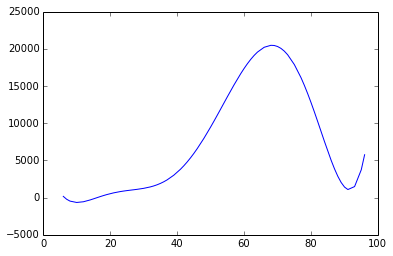

Year 2012, 7 degree polynomial regression
Train R2 0.751639
Test R2 0.711687


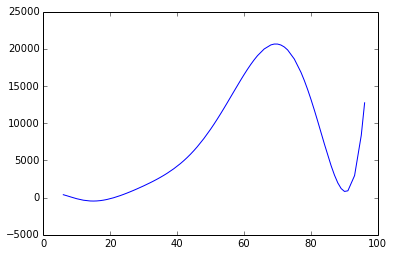

Year 2012, 8 degree polynomial regression
Train R2 0.752488
Test R2 0.734903


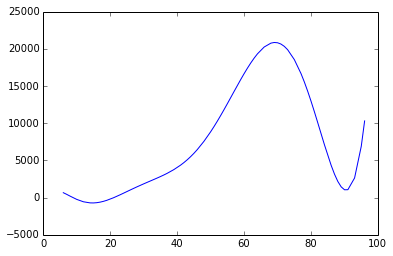

Year 2012, 9 degree polynomial regression
Train R2 0.763852
Test R2 0.739002


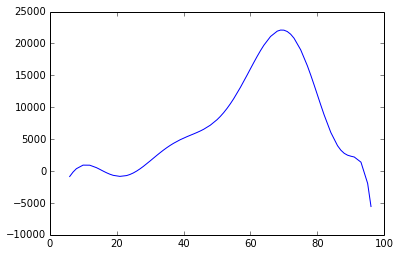

Year 2012, 10 degree polynomial regression
Train R2 0.764906
Test R2 0.723267


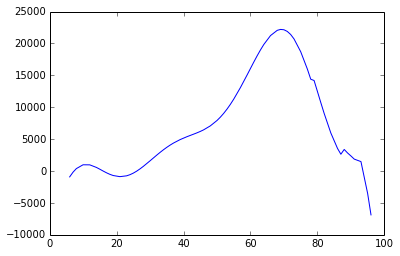

Year 2013, 3 degree polynomial regression
Train R2 0.736140
Test R2 0.670368


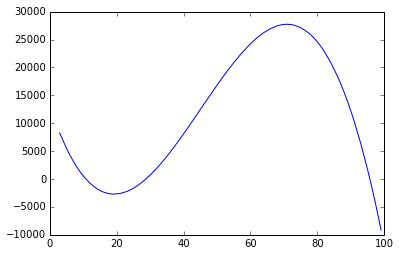

Year 2013, 4 degree polynomial regression
Train R2 0.736566
Test R2 0.666265


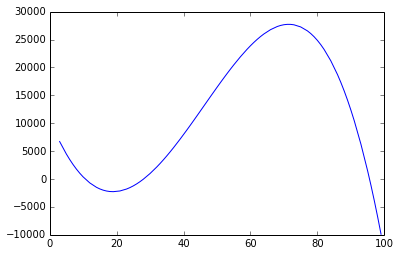

Year 2013, 5 degree polynomial regression
Train R2 0.776938
Test R2 0.761338


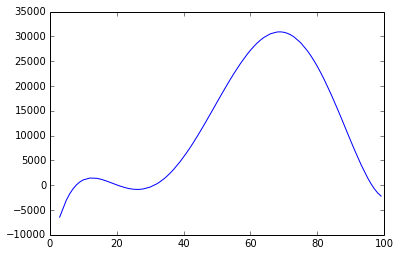

Year 2013, 6 degree polynomial regression
Train R2 0.793072
Test R2 0.764270


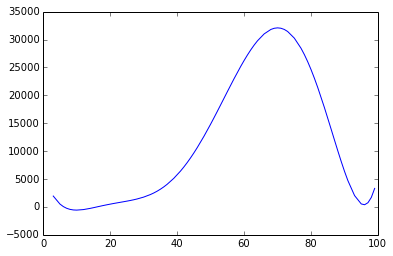

Year 2013, 7 degree polynomial regression
Train R2 0.794585
Test R2 0.749184


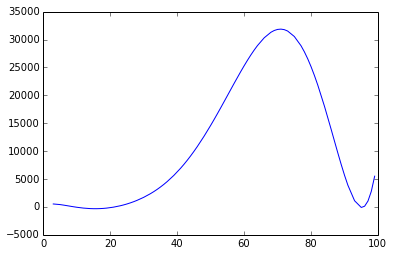

Year 2013, 8 degree polynomial regression
Train R2 0.796590
Test R2 0.755100


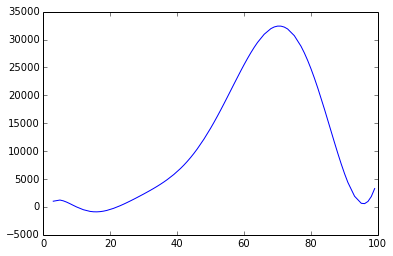

Year 2013, 9 degree polynomial regression
Train R2 0.809681
Test R2 0.717428


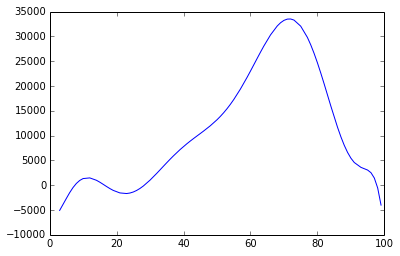

Year 2013, 10 degree polynomial regression
Train R2 0.825513
Test R2 0.678581


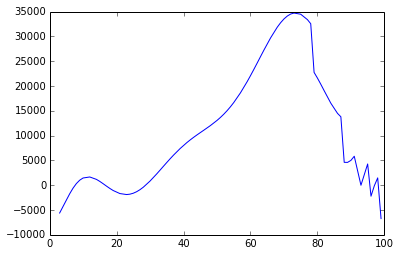

In [11]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(temps)
        plt.plot(temps, y_plot)
        plt.show()

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

In [ ]:
"""
Trying to use a Support Vector Regression (a type of Support Vector Machine)
Does not currently work.
"""

def sup_vec(year):
        
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)
    
    model = SVR()
    model.fit(X_train, y_train, sample_weight=None)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

sup_vec(2011)
sup_vec(2012)
sup_vec(2013)